
# Lesson 15 — EM Algorithm (GMM recap) & Factor Analysis (CS229-style)

This lesson has **two parts**:

1. **Quick EM-for-GMM recap** (because it connects directly to FA)
2. **Factor Analysis (FA)**: a latent-variable model that shines when **n ≪ d**

Why CS229 includes FA here:
- FA is a **Gaussian latent variable model**
- It can be fit with **EM**
- It explains high-dimensional observations using a low-dimensional hidden factor

$$
x = \mu + \Lambda z + \epsilon,\quad z \sim \mathcal{N}(0, I),\quad \epsilon \sim \mathcal{N}(0, \Psi)
$$
- $x \in \mathbb{R}^d$
- $z \in \mathbb{R}^k$ with $k \ll d$
- ($\Psi$) is typically **diagonal** (unique noise per observed dimension)

> **Goal:** see why FA is useful, implement it, and visualize what it learns.


## 0) Setup

In [1]:

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)



## Part A — EM recap: GMM in 15 lines

You already implemented EM-GMM in Lesson 14. Here we just keep a **short reference** cell:
- E-step: compute responsibilities
- M-step: update ($\pi, \mu, \Sigma$)
- log-likelihood should increase

If you want, you can copy/paste your Lesson 14 functions into this notebook.


In [2]:

# Quick sanity: here's a tiny placeholder that shows the EM "shape"
# (Use Lesson 14 implementation for the full version)

# E-step: r_ij = p(z=j | x_i, params)
# M-step: update params using r_ij
# log-likelihood increases each iteration
print("EM recap: see Lesson 14 for full EM-GMM implementation.")


EM recap: see Lesson 14 for full EM-GMM implementation.



## Part B — Factor Analysis (FA)

### Why FA?
FA is a dimensionality reduction model that’s **probabilistic**:
- Unlike PCA, FA explicitly models **per-feature noise** (\(\Psi\))
- Great when you have **high dimension d** and relatively small sample size \(n\)

### Model
$$
x = \mu + \Lambda z + \epsilon
$$
$$
z \sim \mathcal{N}(0, I),\quad \epsilon \sim \mathcal{N}(0, \Psi),\quad \Psi = \mathrm{diag}(\psi_1,\dots,\psi_d)
$$

Then:
$$
x \sim \mathcal{N}(\mu,\; \Lambda \Lambda^T + \Psi)
$$



### We'll generate synthetic FA data

We’ll simulate a case like **n ≪ d**:
- \(n=20\) observed features
- \(k=2\) latent factors
- \(m=120\) samples


In [3]:

def make_fa_data(n=120, d=20, k=2, seed=0):
    rng = np.random.default_rng(seed)
    mu = rng.normal(0, 0.5, size=(n,))

    # loading matrix (n,k)
    Lambda = rng.normal(0, 1.0, size=(n,k))
    # make a few dimensions strongly explained by factors
    Lambda[:5] += 2.0

    # diagonal noise variances
    psi = rng.uniform(0.1, 0.8, size=(n,))
    Psi = np.diag(psi)

    Z = rng.normal(0, 1.0, size=(m,k))              # latent factors
    E = rng.multivariate_normal(np.zeros(d), Psi, size=n)  # noise
    X = mu + Z @ Lambda.T + E                       # (m,n)

    return X, Z, mu, Lambda, psi

X, Z_true, mu_true, Lambda_true, psi_true = make_fa_data(n=120, d=20, k=2, seed=1)
print("X shape:", X.shape, "latent Z shape:", Z_true.shape)


X shape: (120, 20) latent Z shape: (120, 2)



## 1) FA via EM (NumPy)

EM viewpoint:
- Treat \(z_i\) as latent
- E-step: compute $(E[z_i|x_i])$ and $(E[z_i z_i^T|x_i])$
- M-step: update \($\mu$, $\Lambda$, $\Psi$)

Key identities (for diagonal ($\Psi$):
Let $C = \Lambda\Lambda^T + \Psi$. But EM avoids inverting (d $\times$ d) per sample.

Define:
$$
M = I + \Lambda^T \Psi^{-1}\Lambda
$$
Then posterior over \(z\) given \(x\):
$$
E[z|x] = M^{-1}\Lambda^T\Psi^{-1}(x-\mu)
$$
$$
E[zz^T|x] = M^{-1} + E[z|x]E[z|x]^T
$$

We’ll implement this vectorized.


In [4]:

def fa_init(X, k=2, seed=0):
    rng = np.random.default_rng(seed)
    n, d = X.shape
    mu = X.mean(axis=0)

    # init Lambda small
    Lambda = rng.normal(0, 0.2, size=(n,k))
    # init psi as per-feature variance
    psi = X.var(axis=0) + 1e-3
    return mu, Lambda, psi

def fa_e_step(X, mu, Lambda, psi):
    # X: (m,n), mu:(n,), Lambda:(n,k), psi:(n,)
    n, d = X.shape
    k = Lambda.shape[1]

    Xm = (X - mu)                               # (m,n)
    Psi_inv = 1.0 / psi                         # (n,)
    # Compute M = I + Lambda^T Psi^{-1} Lambda
    # Lambda^T Psi^{-1} Lambda = (k,n) * (n,) * (n,k)
    # Implement as: (Lambda * Psi_inv[:,None]) => (n,k), then Lambda.T @ that => (k,k)
    Lt_PsiInv_L = Lambda.T @ (Lambda * Psi_inv[:,None])    # (k,k)
    M = np.eye(k) + Lt_PsiInv_L
    M_inv = np.linalg.inv(M)

    # Ez = M^{-1} Lambda^T Psi^{-1} (x-mu)
    # Compute (x-mu) Psi^{-1} as Xm * Psi_inv
    Xm_PsiInv = Xm * Psi_inv[None,:]            # (m,n)
    Ez = (Xm_PsiInv @ Lambda) @ M_inv.T         # (m,k)  (note: M_inv symmetric)
    # Ezz = sum_i E[zz^T|x_i] but we return per-batch aggregates
    # E[zz^T|x] = M_inv + Ez_i Ez_i^T
    # So sum over i: n*M_inv + Ez^T Ez
    Ezz_sum = n * M_inv + Ez.T @ Ez             # (k,k)
    return Ez, Ezz_sum, M_inv

def fa_m_step(X, Ez, Ezz_sum):
    n, d = X.shape
    k = Ez.shape[1]

    mu = X.mean(axis=0)
    Xm = X - mu

    # Update Lambda: Lambda = (X^T Ez) (Ezz_sum)^{-1}
    Lambda = (Xm.T @ Ez) @ np.linalg.inv(Ezz_sum)          # (n,k)

    # Update psi (diagonal): psi_j = 1/n * sum_i (x_ij - mu_j)^2 - 2 Lambda_j * E[z|x_i] * (x_ij - mu_j) + Lambda_j E[zz^T|x_i] Lambda_j^T
    # Use aggregate form:
    # S = (1/n) Xm^T Xm
    S = (Xm.T @ Xm) / n                                    # (n,n)
    # Compute (1/n) sum_i x_i E[z_i]^T = (1/n) Xm^T Ez
    XEz = (Xm.T @ Ez) / n                                  # (n,k)
    # Compute (1/n) sum_i E[zz^T|x_i] = (1/n) Ezz_sum
    Ezz = Ezz_sum / n                                      # (k,k)

    # For diagonal psi: diag(S - Lambda XEz^T - XEz Lambda^T + Lambda Ezz Lambda^T)
    # But since Lambda = XEz Ezz^{-1} (consistent), simplest stable update:
    recon = Lambda @ XEz.T                                 # (n,n)
    term = Lambda @ Ezz @ Lambda.T                         # (n,n)
    Psi_mat = S - recon - recon.T + term
    psi = np.clip(np.diag(Psi_mat), 1e-6, None)
    return mu, Lambda, psi

def fa_loglik(X, mu, Lambda, psi):
    # log-likelihood of N(mu, Lambda Lambda^T + diag(psi))
    n, d = X.shape
    C = Lambda @ Lambda.T + np.diag(psi) + 1e-6*np.eye(d)
    L = np.linalg.cholesky(C)
    Xm = (X - mu).T  # (n,m)
    sol = np.linalg.solve(L, Xm)   # (n,m)
    quad = np.sum(sol**2, axis=0)  # (m,)
    logdet = 2*np.sum(np.log(np.diag(L)))
    return np.sum(-0.5*(d*np.log(2*np.pi) + logdet + quad))

def em_fa(X, k=2, steps=50, seed=0):
    mu, Lambda, psi = fa_init(X, k=k, seed=seed)
    ll_hist = []
    for _ in range(steps):
        Ez, Ezz_sum, _ = fa_e_step(X, mu, Lambda, psi)
        mu, Lambda, psi = fa_m_step(X, Ez, Ezz_sum)
        ll_hist.append(fa_loglik(X, mu, Lambda, psi))
    return mu, Lambda, psi, np.array(ll_hist)

mu_hat, Lambda_hat, psi_hat, ll_hist = em_fa(X, k=2, steps=60, seed=2)

plt.figure(figsize=(7,4))
plt.plot(ll_hist)
plt.xlabel("EM iteration")
plt.ylabel("Log-likelihood")
plt.title("Factor Analysis EM convergence")
plt.show()

print("psi_hat range:", psi_hat.min(), psi_hat.max())


psi_hat range: 0.08949325984132361 0.7583619421588732



## 2) Visualize what FA learns

### (a) Latent space recovery

We can compute the posterior mean \(E[z|x]\) for each data point and compare its geometry to the true latent \(z\).

Note: FA latent factors are identifiable only up to rotation, so you’re looking for a **similar shape**, not perfect alignment.


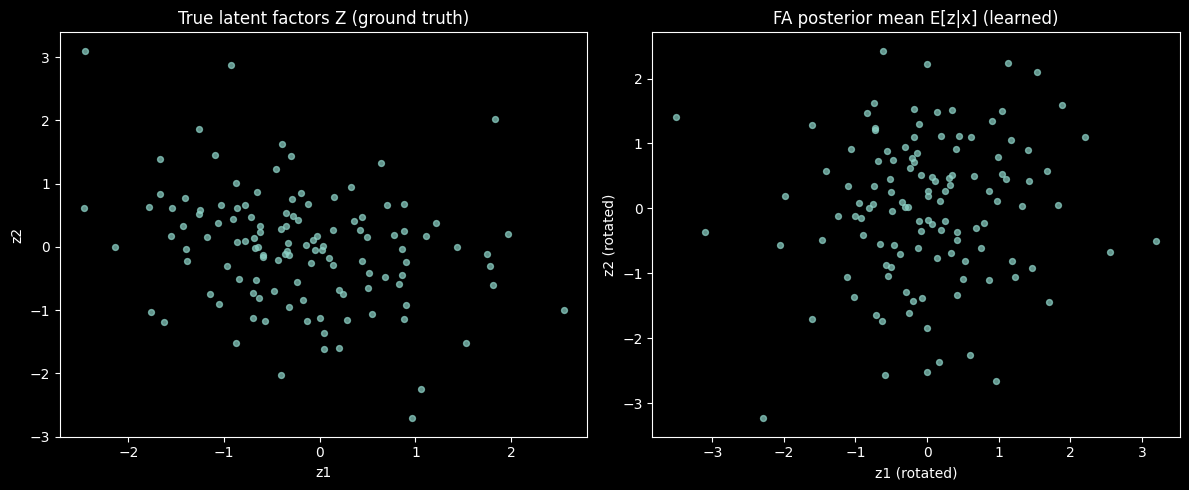

In [5]:

Ez, _, _ = fa_e_step(X, mu_hat, Lambda_hat, psi_hat)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(Z_true[:,0], Z_true[:,1], alpha=0.7, s=18)
plt.title("True latent factors Z (ground truth)")
plt.xlabel("z1")
plt.ylabel("z2")

plt.subplot(1,2,2)
plt.scatter(Ez[:,0], Ez[:,1], alpha=0.7, s=18)
plt.title("FA posterior mean E[z|x] (learned)")
plt.xlabel("z1 (rotated)")
plt.ylabel("z2 (rotated)")

plt.tight_layout()
plt.show()



### (b) Loading matrix heatmap

\(\Lambda\) tells you how each observed dimension loads on the latent factors.


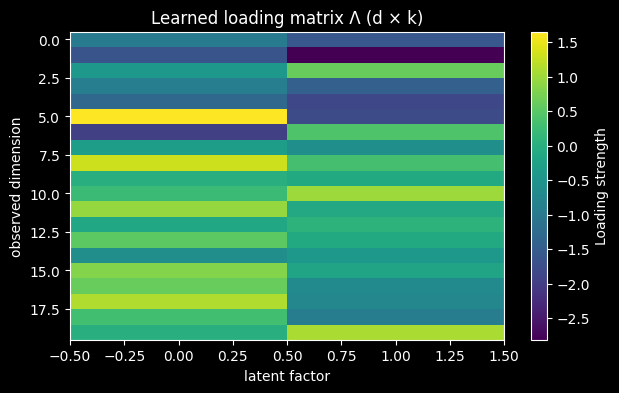

In [6]:

plt.figure(figsize=(7,4))
plt.imshow(Lambda_hat, aspect="auto")
plt.colorbar(label="Loading strength")
plt.title("Learned loading matrix Λ (d × k)")
plt.xlabel("latent factor")
plt.ylabel("observed dimension")
plt.show()



### (c) Unique variances (diagonal Ψ)

These are the per-feature noise levels not explained by the latent factors.


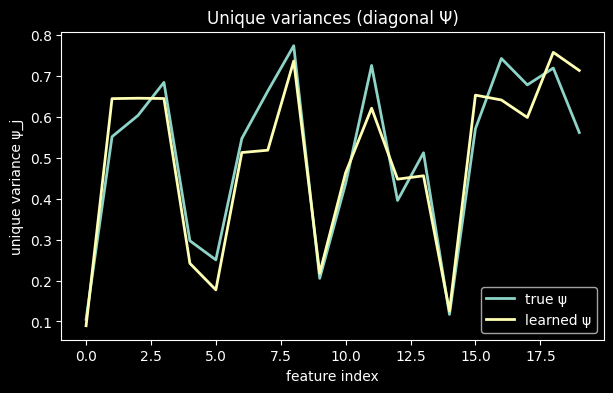

In [7]:

plt.figure(figsize=(7,4))
plt.plot(psi_true, label="true ψ", linewidth=2)
plt.plot(psi_hat, label="learned ψ", linewidth=2)
plt.xlabel("feature index")
plt.ylabel("unique variance ψ_j")
plt.title("Unique variances (diagonal Ψ)")
plt.legend()
plt.show()



## 3) When FA is the right tool (m ≪ n)

FA is especially useful when:
- you have many features (large n)
- relatively few samples (small m)
- you want a **probabilistic** low-dimensional representation
- noise is different per feature (heteroscedastic)

This is common in:
- gene expression / omics
- high-dimensional sensor arrays
- finance panels (many assets, limited history)
- recommendation systems feature blocks



## Key Takeaways (Lesson 15)

### Factor Analysis vs PCA
- **PCA** is a geometric projection method (maximize variance / minimize reconstruction error).
- **FA** is a probabilistic model:
$$
  x = \mu + \Lambda z + \epsilon
$$
  with explicit per-feature noise ($\Psi$).
- FA can be more realistic when each feature has its own noise level.

### When to use Factor Analysis
- You suspect the data is driven by a small number of latent causes ($k \ll n$).
- You care about uncertainty / probabilistic modeling.
- You are in an **m ≪ n** regime where covariance estimation is fragile.
- You want a latent representation that accounts for measurement noise.

### EM perspective
- FA is a latent-variable Gaussian model.
- EM alternates:
  - **E-step:** compute posterior moments \(E[z|x]\), \(E[zz^T|x]\)
  - **M-step:** update ($\Lambda$) and ($\Psi$) using those moments
- The log-likelihood should increase during training (good debugging signal).

### Practical notes
- Factors are identifiable only up to rotation (don’t expect exact recovery).
- Add small diagonal jitter for stability.
- If a variance collapses, clamp \($\psi_j$) with a minimum epsilon.

Next: Lesson 16 (PCA) — connects tightly to FA and shows the deterministic counterpart.
